In [1]:
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
import torchvision.utils
import matplotlib.pyplot as plt
import PIL

In [2]:
transform_start = transforms.Compose([transforms.ToTensor()
                                    ,transforms.Normalize((0.5,), (0.5,)),    # todo-1. Try no transform
                              ])

transform = transforms.Compose([
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0)
        #,transforms.RandomRotation(2.8)
        ,torchvision.transforms.RandomAffine(degrees = 20, translate=None, scale=[0.8,1], shear=None, resample=0, fillcolor=0)
        ,torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=2, fill=0)
        ,torchvision.transforms.GaussianBlur(3, sigma=(0.1))
        ,transforms.ToTensor()
        ,transforms.Normalize((0.5,), (0.5,)),    # todo-1. Try no transform
        ])

train_dataset = datasets.MNIST(root = './', train = True, download = True, transform = transform)
test_dataset = datasets.MNIST(root = './', train = False, download = True, transform = transform_start)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
print(f'{train_dataset.data.shape} {test_dataset.data.shape}')

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [4]:

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64*8, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


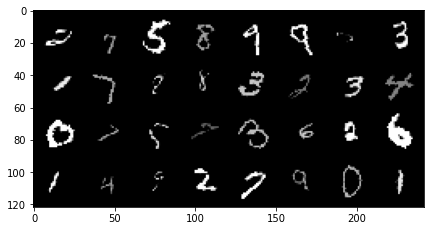

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


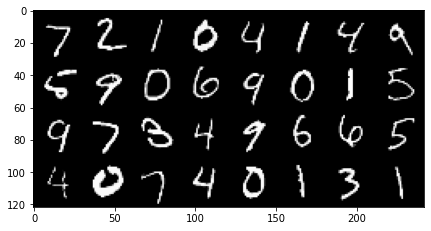

In [5]:
def show_img(img):
  plt.figure(figsize=(7,7))
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

show_img(torchvision.utils.make_grid(iter(train_dataloader).next()[0][:32]))
show_img(torchvision.utils.make_grid(iter(test_dataloader).next()[0][:32]))

tensor(4)

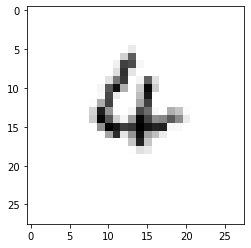

In [6]:
im, lb = iter(train_dataloader).next()
plt.imshow(im[0].squeeze(), cmap='gray_r')
lb[0]

In [7]:
print(im[0].shape)
PIL.Image.fromarray(np.uint8(im[0].squeeze().numpy() * 255) , 'L')

torch.Size([1, 28, 28])


In [8]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [24]:
class ModelNet(nn.Module):
  def __init__(self):
    super(ModelNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1,  out_channels=16, kernel_size=3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=16,  out_channels=32, kernel_size=3, stride=1, padding=0)
    self.res11 = Residual(32, 32, use_1x1conv = False)
    self.res12 = Residual(32, 32, use_1x1conv = False)
    self.res13 = Residual(32, 32, use_1x1conv = False)
    self.res2 = Residual(32, 32, use_1x1conv = True, strides=2)
    self.res3 = Residual(32, 32, use_1x1conv = True, strides=2)
    self.res4 = Residual(32, 32, use_1x1conv = True, strides=2)
    self.conv3 = nn.Conv2d(32, 128, kernel_size=3, padding=0, stride=1)
    self.Lin = nn.Linear(128, 10) 

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.res11(x)
    x = self.res12(x)
    x = self.res13(x)
    x = self.res2(x)
    x = self.res3(x)
    x = self.res4(x)
    x = F.relu(self.conv3(x))
    x = torch.squeeze(x, 3)
    x = torch.squeeze(x, 2)
    x =  self.Lin(x)
    return x


X = torch.rand(4, 1, 28, 28)
model = ModelNet()
print(model(X).shape)
del model

torch.Size([4, 10])


In [25]:
def print_net_layers_shapes(model, X): 
  print(f'Input shape: {X.shape}') 
  #print(f'Output shape: {model(X).shape}') 
  print(f"Кол-во обучаемых параметров {sum(p.numel() for p in model.parameters() if p.requires_grad):,}") 
 
  for i,layer in enumerate(model.modules()):   
    layer_name = layer.__class__.__name__ 
    if sum(1 for x in layer.children()) > 0:  
      print(f'Net name: {layer_name}') 
      continue # skip top level Network  
    if 'Conv2d' in layer_name and layer.kernel_size == (1,1): # use_1x1conv in Residual
      continue
    if 'Linear' in layer_name:  
      X = X.view(X.size(0), -1)
    X = layer(X)   
    print(layer_name.rjust(18),'output shape: ', X.shape) 
 
tmp_model = ModelNet() 
X = torch.rand(size=(2, 1, 28, 28))
print_net_layers_shapes(tmp_model, X) #X = torch.rand(size=(2, 3, 141, 141))  

del tmp_model 

Input shape: torch.Size([2, 1, 28, 28])
Кол-во обучаемых параметров 157,994
Net name: ModelNet
            Conv2d output shape:  torch.Size([2, 16, 26, 26])
            Conv2d output shape:  torch.Size([2, 32, 24, 24])
Net name: Residual
            Conv2d output shape:  torch.Size([2, 32, 24, 24])
       BatchNorm2d output shape:  torch.Size([2, 32, 24, 24])
            Conv2d output shape:  torch.Size([2, 32, 24, 24])
       BatchNorm2d output shape:  torch.Size([2, 32, 24, 24])
              ReLU output shape:  torch.Size([2, 32, 24, 24])
Net name: Residual
            Conv2d output shape:  torch.Size([2, 32, 24, 24])
       BatchNorm2d output shape:  torch.Size([2, 32, 24, 24])
            Conv2d output shape:  torch.Size([2, 32, 24, 24])
       BatchNorm2d output shape:  torch.Size([2, 32, 24, 24])
              ReLU output shape:  torch.Size([2, 32, 24, 24])
Net name: Residual
            Conv2d output shape:  torch.Size([2, 32, 24, 24])
       BatchNorm2d output shape:  torch.Si

In [27]:
def get_all_preds(net, loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    for images, labels in loader:
        images = images.to(cuda_device)
        preds = net(images)
        all_preds = torch.cat(
            (all_preds, preds.to('cpu').argmax(dim=1))
            ,dim=0
        )
        all_labels = torch.cat(
            (all_labels, labels)
            ,dim=0
        )
    return all_labels, all_preds

In [28]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def get_test_statistics(net, test_dataloader):
  test_labels, test_preds = get_all_preds(net, test_dataloader)

  confusion_matrix = torch.zeros(10, 10, dtype=torch.int64)
  stacked = torch.stack(
      (test_labels,test_preds)
      ,dim=1
  )
  alln = len(test_labels)
  correctn = 0
  error_indx = []
  for i, p in enumerate(stacked):
      tl, pl = map(int, p)
      correct = tl == pl
      if correct:
        correctn += 1
      else:
        error_indx.append(i)
      confusion_matrix[tl, pl] += 1
  accuracy = correctn/alln
  return accuracy, confusion_matrix, error_indx

def show_confusion_matrix(conf_matrix):
  display_labels=[str(i) for i in range(10)]
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=display_labels)
  
  #figure(figsize=(8, 6)
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(111)
  print(f'accuracy = {accuracy}')
  disp.plot(values_format = '', ax = ax) 

In [33]:
def show_error_imgs(error_indx, test_dataloader):
  s = set(error_indx)
  
  error_ims = []
  error_labs = []
  for i, (ims, lab) in enumerate(test_dataloader):
    for j, im  in enumerate(ims):
      if i*64+j in s:
        error_ims.append(im)
        error_labs.append(lab[j].item())

  show_img(torchvision.utils.make_grid(error_ims[:64]))
  for i in range(8):
    print(error_labs[0+i*8:8+i*8])

In [30]:
cuda_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = ModelNet().to(device=cuda_device)
criterion = nn.CrossEntropyLoss()

In [39]:
#optimizer = optim.Adam(net.parameters(), lr=0.0001)  # start learning with Adam, continue with SGD
optimizer = optim.SGD(net.parameters(), lr=0.0001)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=1,threshold =1e-2, verbose=True)


118it [01:25,  1.38it/s]


117.  total_loss = 4.230894601903856


0it [00:00, ?it/s]

accuracy = 0.9953



118it [01:24,  1.40it/s]


117.  total_loss = 4.144985121674836


0it [00:00, ?it/s]

accuracy = 0.9953



118it [01:24,  1.40it/s]


117.  total_loss = 4.540871299803257


0it [00:00, ?it/s]

accuracy = 0.9953



118it [01:25,  1.38it/s]


117.  total_loss = 4.1000323528423905


0it [00:00, ?it/s]

accuracy = 0.9953



118it [01:25,  1.38it/s]


117.  total_loss = 4.138222549576312


0it [00:00, ?it/s]

accuracy = 0.9953



118it [01:25,  1.38it/s]


117.  total_loss = 4.227817375212908


0it [00:00, ?it/s]

accuracy = 0.9953



118it [01:25,  1.37it/s]


117.  total_loss = 4.330952130258083


0it [00:00, ?it/s]

accuracy = 0.9952



118it [01:25,  1.39it/s]


117.  total_loss = 4.270304815843701


0it [00:00, ?it/s]

accuracy = 0.9951



118it [01:24,  1.40it/s]


117.  total_loss = 4.099488480016589


0it [00:00, ?it/s]

accuracy = 0.9951



118it [01:23,  1.42it/s]


117.  total_loss = 4.327960949391127


0it [00:00, ?it/s]

accuracy = 0.9952



118it [01:23,  1.41it/s]


117.  total_loss = 4.055626325309277


0it [00:00, ?it/s]

accuracy = 0.9951



118it [01:22,  1.43it/s]


117.  total_loss = 4.07886104285717


0it [00:00, ?it/s]

accuracy = 0.9951



118it [01:23,  1.42it/s]


117.  total_loss = 4.036300223320723


0it [00:00, ?it/s]

accuracy = 0.9951



118it [01:22,  1.42it/s]


117.  total_loss = 4.223599441349506


0it [00:00, ?it/s]

accuracy = 0.995



118it [01:23,  1.42it/s]


117.  total_loss = 4.479768653400242


0it [00:00, ?it/s]

accuracy = 0.995



118it [01:23,  1.42it/s]


117.  total_loss = 4.243279218673706


0it [00:00, ?it/s]

accuracy = 0.9951



118it [01:22,  1.42it/s]


117.  total_loss = 4.189020186662674


0it [00:00, ?it/s]

accuracy = 0.9951



118it [01:23,  1.41it/s]


117.  total_loss = 4.178586371243


0it [00:00, ?it/s]

accuracy = 0.9951



118it [01:25,  1.38it/s]


117.  total_loss = 4.114887411240488


0it [00:00, ?it/s]

accuracy = 0.995



118it [01:26,  1.36it/s]


117.  total_loss = 4.295829098671675
accuracy = 0.9952

accuracy = 0.9952


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


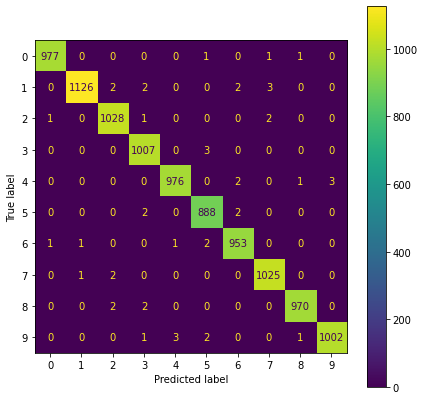

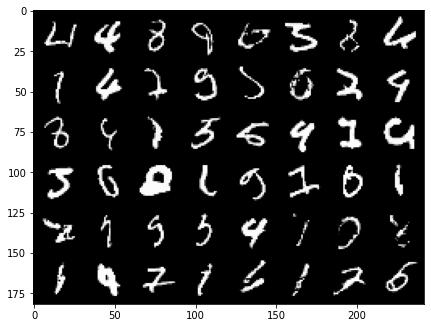

[4, 4, 8, 9, 6, 3, 8, 6]
[1, 4, 7, 9, 5, 0, 2, 9]
[8, 9, 1, 5, 5, 4, 1, 9]
[3, 6, 2, 6, 9, 1, 0, 1]
[2, 1, 9, 3, 4, 7, 0, 8]
[1, 4, 7, 1, 6, 1, 2, 5]
[]
[]


In [40]:
from tqdm import tqdm
for epoch in range(20):
  total_loss = 0
  iterations = len(train_dataloader)
  for iteration, (X, labels) in tqdm(enumerate(train_dataloader)):
    net.train()
    X, labels = X.to(device=cuda_device), labels.to(device=cuda_device)
    optimizer.zero_grad()
    y = net(X)
    loss = criterion(y,labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  print(f'{iteration}.  total_loss = {total_loss}')
  accuracy, conf_matrix, error_indx = get_test_statistics(net, test_dataloader)
  print(f'accuracy = {accuracy}')
  print()

show_confusion_matrix(conf_matrix)
show_error_imgs(error_indx, test_dataloader)